_Lambda School Data Science — Regression 2_ 

This sprint, your project is Caterpillar Tube Pricing: Predict the prices suppliers will quote for industrial tube assemblies.

# Cross-Validation, Hyperparameter Optimization 🚜


### Objectives
- Do cross-validation with independent test set
- Use scikit-learn for hyperparameter optimization

### Install libraries

We will continue to use [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding) and [xgboost](https://xgboost.readthedocs.io/en/latest/).


#### category_encoders
- Anaconda: `conda install -c conda-forge category_encoders`
- Google Colab: `pip install category_encoders`

#### xgboost
- Anaconda, Mac/Linux: `conda install -c conda-forge xgboost`
- Windows: `conda install -c anaconda py-xgboost`
- Google Colab: already installed

In [0]:
# # Uncomment & run for Google Colab
# !pip install category_encoders

### Get data

We will continue to use the Caterpillar dataset.

#### Option 1. Kaggle web UI
 
Sign in to Kaggle and go to the [Caterpillar Tube Pricing](https://www.kaggle.com/c/caterpillar-tube-pricing) competition. Go to the Data page. After you have accepted the rules of the competition, use the download buttons to download the data.


#### Option 2. Kaggle API

Follow these [instructions](https://github.com/Kaggle/kaggle-api).

#### Option 3. Google Drive

Download [zip file](https://drive.google.com/uc?export=download&id=1oGky3xR6133pub7S4zIEFbF4x1I87jvC) from Google Drive.

In [0]:
# # Uncomment & run for Option 3 on Google Colab
# from google.colab import files
# files.upload()

In [0]:
# !unzip caterpillar-tube-pricing.zip

In [0]:
# !unzip data.zip

### Wrangle data

This code is similar to what you've seen in  previous notebooks this sprint. We will continue to do the same kind of data wrangling, to prepare our data for cross-validation and hyperparameter optimization. You will likely engineer more features than this!

In [3]:
import category_encoders as ce
from glob import glob
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline

# Read data
train = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')
tube = pd.read_csv('competition_data/tube.csv')
materials = pd.read_csv('competition_data/bill_of_materials.csv')
components = pd.read_csv('competition_data/components.csv')
comp = pd.concat((pd.read_csv(path) for path in glob('competition_data/comp_*.csv')), sort=False)

# Get a tidy list of the component types in each tube assembly
assembly_components = materials.melt(id_vars='tube_assembly_id', 
                                     value_vars=[f'component_id_{n}' for n in range(1,9)])

assembly_components = (assembly_components
                       .sort_values(by='tube_assembly_id')
                       .dropna()
                       .rename(columns={'value': 'component_id'}))

assembly_component_types = assembly_components.merge(components, how='left')

# Make a crosstab of the component types for each assembly (one-hot encoding)
table = pd.crosstab(assembly_component_types['tube_assembly_id'], 
                    assembly_component_types['component_type_id'])
table = table.reset_index()

# Get features for each component
features = ['component_id', 'component_type_id', 'orientation', 'unique_feature', 'weight']
comp = comp[features]
comp['orientation'] = (comp['orientation']=='Yes').astype(int)
comp['unique_feature'] = (comp['unique_feature']=='Yes').astype(int)
comp['weight'] = comp['weight'].fillna(comp['weight'].median())

# Get aggregated features for all components in each tube assembly.
# This code is a little complex, but we discussed in detail last lesson.
materials['components_total'] = sum(materials[f'quantity_{n}'].fillna(0)  for n in range(1,9))
materials['components_distinct'] = sum(materials[f'component_id_{n}'].notnull().astype(int) for n in range(1,9))
materials['orientation'] = 0
materials['unique_feature'] = 0
materials['weight'] = 0

for n in range(1,9):
    materials = materials.merge(comp, how='left', 
                                left_on=f'component_id_{n}', 
                                right_on='component_id', 
                                suffixes=('', f'_{n}'))

for col in materials:
    if 'orientation' in col or 'unique_feature' in col or 'weight' in col:
        materials[col] = materials[col].fillna(0)
        
materials['orientation'] = sum(materials[f'orientation_{n}'] for n in range(1,9))
materials['unique_feature'] = sum(materials[f'unique_feature_{n}'] for n in range(1,9))
materials['weight'] = sum(materials[f'weight_{n}'] for n in range(1,9))

features = ['tube_assembly_id', 'orientation', 'unique_feature', 'weight', 
            'components_total', 'components_distinct', 'component_id_1']
materials = materials[features]

# Extract year from quote date
train['quote_date_year'] = pd.to_datetime(train['quote_date'], infer_datetime_format=True).dt.year
test['quote_date_year'] = pd.to_datetime(train['quote_date'], infer_datetime_format=True).dt.year

# Merge data
train = (train
         .merge(tube, how='left')
         .merge(materials, how='left')
         .merge(table, how='left')
         .fillna(0))

test = (test
        .merge(tube, how='left')
        .merge(materials, how='left')
        .merge(table, how='left')
        .fillna(0))

# Arrange X matrix and y vector.
# Drop `tube_assembly_id` because our goal is to predict unknown assemblies,
# and no tube assembly id's are shared between the train and test sets.
target = 'cost'
features = train.columns.drop([target, 'tube_assembly_id'])
X_train = train[features]
y_train = train[target]
X_test = test[features]

# Log-transform the target
y_train_log = np.log1p(y_train)

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

## Do cross-validation with independent test set

Let's take another look at [Sebastian Raschka's diagram of model evaluation methods.](https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html) So far we've been using "**train/validation/test split**", but we have more options. 

Today we'll learn about "k-fold **cross-validation** with independent test set", for "model selection (**hyperparameter optimization**) and performance estimation."

<img src="https://sebastianraschka.com/images/blog/2018/model-evaluation-selection-part4/model-eval-conclusions.jpg" width="600">

<sup>Source: https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html</sup>



The Scikit-Learn docs show a diagram of how k-fold cross-validation works, and explain the pros & cons of cross-validation versus train/validate/test split.

#### [Scikit-Learn User Guide, 3.1 Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)

> When evaluating different settings (“hyperparameters”) for estimators, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.

> However, **by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.**

> **A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV.** 

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="600">

> In the basic approach, called k-fold CV, the training set is split into k smaller sets. The following procedure is followed for each of the k “folds”:

> - A model is trained using $k-1$ of the folds as training data;
> - the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

> The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. **This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set).**

### cross_val_score

How do we get started? According to the [Scikit-Learn User Guide](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics), 

> The simplest way to use cross-validation is to call the [**`cross_val_score`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) helper function

However, this isn't _so_ simple with the Caterpillar dataset, because:

- We want all rows for a given `tube_assembly_id` to go into the same "fold." (Why? [See the discussion here](https://www.fast.ai/2017/11/13/validation-sets/) under _"New people, new boats"_ for a reminder.) We can do this with the `cross_val_score` function, using its `groups` parameter.
- For scikit-learn's cross-validation [**scoring**](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter), higher is better. But for regression error metrics, lower is better. So scikit-learn multiplies regression error metrics by -1 to make them negative. That's why the value of the `scoring` parameter is `'neg_mean_squared_error'`. 
- Scikit-learn doesn't implement RMSE, so we take the square root of MSE. First, we must multiply the scores by -1 to make them positive.
- RMSE with the log-transformed target is equivalent to RMSLE with the original target.

Put it all together, and k-fold cross-validation with the Caterpillar dataset looks like this:

In [4]:
%%time
from sklearn.model_selection import cross_val_score

k = 3
groups = train['tube_assembly_id']
scores = cross_val_score(pipeline, X_train, y_train_log, cv=k, 
                         scoring='neg_mean_squared_error', groups=groups)
print(f'RMSLE for {k} folds:', np.sqrt(-scores))

RMSLE for 3 folds: [0.29120347 0.32190414 0.34660462]
CPU times: user 9.07 s, sys: 2.89 s, total: 12 s
Wall time: 4min 26s


But the Random Forest has many hyperparameters. We mostly used the defaults, and arbitrarily chose `n_estimators`. Is it too high? Too low? Just right? How do we know?

In [5]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestregressor'])

Model Hyperparameters:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)


"The universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it." —[Francois Chollet](https://books.google.com/books?id=dadfDwAAQBAJ&pg=PA114)

### Validation Curve

Let's try different parameter values, and visualize "the border between underfitting and overfitting." 

Using scikit-learn, we can make [validation curves](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html), "to determine training and test scores for varying parameter values. This is similar to grid search with one parameter."

<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png">

<sup>Source: https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn</sup>

Validation curves are awesome for learning about overfitting and underfitting. (But less useful in real-world projects, because we usually want to vary more than one parameter.)

For this example, let's see what happens when we vary the depth of a decision tree. (This will be faster than varying the number of estimators in a random forest.)

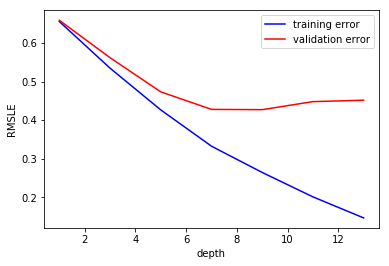

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor

pipeline = make_pipeline(ce.OrdinalEncoder(), DecisionTreeRegressor())

depth = range(1, 15, 2)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train_log,
    param_name='decisiontreeregressor__max_depth', 
    param_range=depth, scoring='neg_mean_squared_error', 
    cv=2, groups=groups)

train_rmsle = np.sqrt(-train_scores)
val_rmsle = np.sqrt(-val_scores)
plt.plot(depth, np.mean(train_rmsle, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(val_rmsle, axis=1), color='red', label='validation error')
plt.xlabel('depth')
plt.ylabel('RMSLE')
plt.legend();

## Use scikit-learn for hyperparameter optimization

To vary multiple hyperparameters and find their optimal values, let's try **Randomized Search CV.**

#### [Scikit-Learn User Guide, 3.2 Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)

> Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. 

> While using a grid of parameter settings is currently the most widely used method for parameter optimization, other search methods have more favourable properties. [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) implements a randomized search over parameters, where each setting is sampled from a distribution over possible parameter values.

> Specifying how parameters should be sampled is done using a dictionary. Additionally, a computation budget, being the number of sampled candidates or sampling iterations, is specified using the `n_iter` parameter. 

For the sake of time, let's just do 5 iterations of randomized search, with 2-fold cross-validation.

In [7]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_features': uniform(), 
    'randomforestregressor__min_samples_leaf':  [1, 10, 100]
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train_log, groups=groups);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  5.4min remaining:  5.4min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  5.9min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  7.1min finished


In [8]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'randomforestregressor__max_features': 0.6673298391163184, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__n_estimators': 342}
Cross-validation RMSLE 0.32712068733933747


The score may be underwhelming to you, but it's just a demo. Try it after the lesson, with all your features, for more iterations.

### "Fitting X folds for each of Y candidates, totalling Z fits" ?

What did that mean? What do you think?



### Do it with xgboost

In [ ]:
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(random_state=42)
)

param_distributions = {
    'xgbregressor__n_estimators': randint(500, 1000), 
    'xgbregressor__max_depth': randint(3, 7)
}

search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_squared_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train_log, groups=groups);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [ ]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation RMSLE', np.sqrt(-search.best_score_))

### See detailed results

In [0]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

### Make predictions to submit to Kaggle

In [0]:
pipeline = search.best_estimator_
y_pred_log = pipeline.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Convert from log-dollars to dollars
submission = pd.read_csv('sample_submission.csv')
submission['cost'] = y_pred
submission.to_csv('submission.csv', index=False)

# ASSIGNMENT
- Use the Caterpillar dataset (or _any_ dataset of your choice). 
- Use scikit-learn for hyperparameter optimization with RandomSearchCV.
- Add comments and Markdown to your notebook. Clean up your code.
- Commit your notebook to your fork of the GitHub repo.

### Stretch Goals
- Make your final Kaggle submissions. Improve your scores! Look at [Kaggle Kernels](https://www.kaggle.com/c/caterpillar-tube-pricing/kernels) for ideas. **Share your best features and techniques on Slack.**
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?

### Post-Reads
- Jake VanderPlas, [_Python Data Science Handbook_, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [_A Programmer's Guide to Data Mining_, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)

## Try adjusting these hyperparameters in your future projects

### Tree ensembles

#### Random Forest
- class_weight (for imbalanced classes)
- max_depth (usually high)
- max_features (decrease for more variance)
- min_samples_leaf (increase if overfitting)
- n_estimators (too low underfits, too high wastes time)

#### Xgboost
- scale_pos_weight (for imbalanced classes)
- max_depth (usually low)
- n_estimators (too low underfits, too high overfits)

For more ideas, see [Notes on Parameter Tuning](https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html) and [DART booster](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html).

### Linear models

#### Logistic Regression
- C
- class_weight (for imbalanced classes)
- penalty

#### Ridge / Lasso Regression
- alpha

#### ElasticNet Regression
- alpha
- l1_ratio

For more explanation, see [**Aaron Gallant's 9 minute video on Ridge Regression**](https://www.youtube.com/watch?v=XK5jkedy17w)!
